In [1]:
import requests
import time
import calendar
import dateutil.parser as parser
from dateutil.relativedelta import relativedelta
from datetime import datetime, timezone
import pandas as pd
import numpy as np
import warnings
import yaml
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')
from pycaret.datasets import get_data
from pycaret.classification import *

### Get Candlestick Data

In [2]:
now = datetime.now()

In [3]:
with open ('back_test_pipeline_settings.yaml') as ymlfile:
    cfg = yaml.safe_load(ymlfile)
    k_number = cfg['knn']['k_number']
    metric = cfg['knn']['metric']
    algorithm = cfg['knn']['algorithm']
    feature_1 = cfg['knn']['feature_1']
    feature_2 = cfg['knn']['feature_2']
    feature_3 = cfg['knn']['feature_3']
    feature_7 = cfg['knn']['feature_7']
    feature_8 = cfg['knn']['feature_8']
    feature_9 = cfg['knn']['feature_9']
    feature_10 = cfg['knn']['feature_10']
    feature_11 = cfg['knn']['feature_11']
    feature_12 = cfg['knn']['feature_12']
    feature_13 = cfg['knn']['feature_13']
    feature_14 = cfg['knn']['feature_14']
    volume = cfg['feature']['volume']
    volume_size = cfg['sample']['volume_size']
    sample_count = cfg['sample']['count']
    candles = cfg['recommendation']['candle_count']
    pair = cfg['currency']['pair']
    instrument = cfg['currency']['instrument']
    frac = cfg['model']['frac']
    random_state = cfg['model']['random_state']
    model = cfg['model']['name']

In [4]:
print('K Number:',k_number)
print('Metric:', metric)
print('Algorithm:', algorithm)
print('Candle Volume Size:', volume_size)
print('Random Sample Count:', sample_count)
print('Future Candle Count:', candles)
print('Pair:', pair)


K Number: 5
Metric: euclidean
Algorithm: brute
Candle Volume Size: 5500
Random Sample Count: 4000
Future Candle Count: 7
Pair: EURUSD


In [5]:
with open ('config.yml') as ymlfile:
    cfg = yaml.safe_load(ymlfile)
    oanda_api_key = cfg['creds']['oanda_api']
    account_number = cfg['creds']['account_number'] 

In [6]:
def convert_date(utc_time): 
    parsed_date = parser.parse(utc_time)
    var_date=parsed_date.date()
    var_time=parsed_date.time()
    var_f_time=var_time.hour
    var_julian_date=parsed_date.timetuple().tm_yday
    var_weekday=parsed_date.weekday()
    var_weekday_name=calendar.day_name[parsed_date.weekday()]
    return var_date, var_time, var_f_time, var_julian_date, var_weekday, var_weekday_name

In [7]:
print('Instrument:', instrument)

Instrument: EUR_USD


In [8]:
Load_10K_Records=True
Load_20K_Records=False

currency_pairs = [instrument]


timeframe = "H4"
#D #H1 #H4 M30
# https://developer.oanda.com/rest-live-v20/instrument-df/#CandlestickGranularity
price_char = "M"
#M(midpoint candles) #B(bid candles) #A(ask candles) #BA
price_com = "mid"
#mid #bid #ask

# def of OANDA request variable
provider_api_url = 'https://api-fxpractice.oanda.com/v3/accounts/{}/orders'.format(account_number)
request_headers = {
    "Authorization": oanda_api_key,
    "Accept-Datetime-Format": "RFC3339",
    "Connection": "Keep-Alive",
    "Content-Type": "application/json;charset=UTF-8"
}


In [9]:
provider_authorization = 'Bearer {0}'.format(oanda_api_key)

headers = {
    'Content-Type': 'application/json',
    'Authorization': provider_authorization,
}

In [10]:
params_count = (
    ('price', price_char),
    ('count', '5000'),
    ('granularity', timeframe),
)


In [11]:
for pair in currency_pairs:
    first_response = requests.get('https://api-fxpractice.oanda.com/v3/instruments/{}/candles'.format(pair), 
                            headers=headers,
                            params=params_count).json()

In [12]:
if Load_10K_Records:
    
    #### Load 10K data
        
    datetime_object = parser.parse(first_response['candles'][0]['time'])
    date= datetime_object - relativedelta(years=3)  
    from_date = date.replace(tzinfo=timezone.utc).timestamp()
    params_date = (
        ('count', '5000'),
        ('price', price_char),
        ('from', from_date),
        ('granularity', timeframe),)

    second_response = requests.get('https://api-fxpractice.oanda.com/v3/instruments/{}/candles'.format(pair),
                                   headers=headers,
                                   params=params_date).json()
    datetime_object_15K = parser.parse(second_response['candles'][0]['time'])
    first_response= first_response['candles']  
    second_response= second_response['candles']
    second_response.extend(first_response)
    
    if Load_20K_Records:

        #### Load 15K data

        date= datetime_object_15K - relativedelta(years=3)  
        from_date = date.replace(tzinfo=timezone.utc).timestamp()
        params_date = (
            ('count', '5000'),
            ('price', price_char),
            ('from', from_date),
            ('granularity', timeframe),)

        third_response = requests.get('https://api-fxpractice.oanda.com/v3/instruments/{}/candles'.format(pair),
                                       headers=headers,
                                       params=params_date).json()
        datetime_object_20K = parser.parse(third_response['candles'][0]['time'])
        third_response= third_response['candles']
        third_response.extend(second_response)

        #### Load 20K data

        date= datetime_object_20K - relativedelta(years=3)  
        from_date = date.replace(tzinfo=timezone.utc).timestamp()
        params_date = (
            ('count', '5000'),
            ('price', price_char),
            ('from', from_date),
            ('granularity', timeframe),)

        fourth_response = requests.get('https://api-fxpractice.oanda.com/v3/instruments/{}/candles'.format(pair),
                                       headers=headers,
                                       params=params_date).json()
        datetime_object_20K = parser.parse(fourth_response['candles'][0]['time'])
        fourth_response= fourth_response['candles']
        fourth_response.extend(third_response)

        response=fourth_response
    else:
       response=second_response 
else:
    response=first_response['candles']

In [13]:
filename = "{}_{}.csv".format(pair, timeframe)
output = []
all_candlesticks = response

for i in range (len(all_candlesticks)):
    result= (convert_date(response[i]['time']))
    output.append([(result[0]),(result[1]),(result[2]),(result[3]),(result[4]),(result[5]),
                    response[i]['time'],
                    response[i]['volume'], 
                    response[i][price_com]['o'],
                    response[i][price_com]['h'],
                    response[i][price_com]['l'],
                    response[i][price_com]['c']])
    
output = pd.DataFrame(output)
output.columns = ['Date','Time','f_time','julian_date','Weekday','Weekday_Name','UTC_Time', 'Volume', 'Open', 'High', 'Low', 'Close']
data = output.to_csv(filename, header = True, index = False)
data = pd.read_csv(filename)

In [14]:
data = data.drop_duplicates()
data = data.to_csv(filename, header = True, index = False)
data = pd.read_csv(filename)

In [15]:
data.shape

(9670, 12)

In [16]:
data['SMA_5'] = data['Close'].rolling(window=5).mean().round(4)
data['SMA_10'] = data['Close'].rolling(window=10).mean().round(4)
data['SMA_20'] = data['Close'].rolling(window=20).mean().round(4)

In [17]:
data['F_SMA_5'] = data['Close'] - data['SMA_5']
data['F_SMA_10'] = data['Close'] - data['SMA_10']
data['F_SMA_20'] = data['Close'] - data['SMA_20']

In [18]:
data = data.drop_duplicates()
data = data.to_csv(filename, header = True, index = False)
data = pd.read_csv(filename)

In [19]:
data['O-H'] = data['Open'] - data['High']
data['O-L'] = data['Open'] - data['Low']
data['O-C'] = data['Open'] - data['Close']
data['H-L'] = data['High'] - data['Low']
data['H-C'] = data['High'] - data['Close']
data['L-C'] = data['Low'] - data['Close']

data['Direction'] = data['O-C'].apply(lambda x: 1 if x<0 else 0)

data['col_1'] = data['Open'] - data['Close']

for value in data['col_1']:   
    if value > 0:
        data['col_2'] = data['High'] - data['Open']
        data['col_3'] = data['Close'] - data['Low']
    else:
        data['col_2'] = data['High'] - data['Close']
        data['col_3'] = data['Open'] - data['Low']

#Two Previous Candlesticks 
data['col_4'] = data['col_1'].shift(1)
data['col_5'] = data['col_1'].shift(2)

In [20]:
data = data.dropna()
data = data.to_csv(filename, header = True, index = False)
data = pd.read_csv(filename)

In [21]:
data.describe()

,f_time,julian_date,Weekday,Volume,Open,High,Low,Close,SMA_5,SMA_10,SMA_20,F_SMA_5,F_SMA_10,F_SMA_20,O-H,O-L,O-C,H-L,H-C,L-C,Direction,col_1,col_2,col_3,col_4,col_5
count,9651.000000,9651.000000,9651.000000,9651.000000,9651.000000,9651.000000,9651.000000,9651.000000,9651.000000,9651.000000,9651.000000,9651.000000,9651.000000,9651.000000,9651.000000,9651.000000,9651.000000,9651.000000,9651.000000,9651.000000,9651.000000,9651.000000,9651.000000,9651.000000,9651.000000,9651.000000
mean,11.368666,182.769039,2.067351,8948.778779,1.142644,1.144099,1.141225,1.142656,1.142639,1.142618,1.142578,0.000016,0.000038,0.000078,-0.001454,0.001419,-0.000012,0.002873,0.001443,-0.001430,0.505440,-0.000012,0.001443,0.001419,-0.000011,-0.000011
std,6.849653,107.221859,1.545450,9233.393484,0.045653,0.045616,0.045650,0.045645,0.045622,0.045602,0.045561,0.002260,0.003442,0.005048,0.001576,0.001557,0.002088,0.002023,0.001515,0.001493,0.499996,0.002088,0.001515,0.001557,0.002088,0.002088
min,1.000000,1.000000,0.000000,1.000000,1.036950,1.039150,1.034060,1.036980,1.038700,1.039500,1.041600,-0.032270,-0.034970,-0.034470,-0.033220,0.000000,-0.027380,0.000000,0.000000,-0.030040,0.000000,-0.027380,0.000000,0.000000,-0.027380,-0.027380
25%,5.000000,89.000000,1.000000,2879.500000,1.110555,1.112030,1.109280,1.110665,1.110650,1.110700,1.110500,-0.001140,-0.001980,-0.002990,-0.001920,0.000430,-0.000980,0.001540,0.000490,-0.001890,0.000000,-0.000980,0.000490,0.000430,-0.000980,-0.000980
50%,13.000000,183.000000,2.000000,5613.000000,1.134760,1.136260,1.133500,1.134760,1.134600,1.134500,1.134500,0.000010,-0.000040,-0.000020,-0.001010,0.000950,-0.000020,0.002380,0.001000,-0.001010,1.000000,-0.000020,0.001000,0.000950,-0.000020,-0.000020
75%,17.000000,276.500000,3.000000,11793.000000,1.178700,1.180055,1.177270,1.178685,1.178600,1.178500,1.178600,0.001200,0.002000,0.003060,-0.000460,0.001890,0.000910,0.003625,0.001890,-0.000480,1.000000,0.000910,0.001890,0.001890,0.000910,0.000910
max,22.000000,366.000000,6.000000,107306.000000,1.254930,1.255600,1.252340,1.254940,1.251400,1.249100,1.245700,0.020680,0.025710,0.030010,0.000000,0.036470,0.032810,0.038520,0.034860,0.000000,1.000000,0.032810,0.034860,0.036470,0.032810,0.032810


In [22]:
data.shape

(9651, 30)

### Generating Training Data

In [23]:
print('K Number:',k_number)
print('Metric:', metric)
print('Algorithm:', algorithm)

K Number: 5
Metric: euclidean
Algorithm: brute


In [24]:
def find_k_similar_candles(candle_id, dataset, k = k_number):
    indices=[]
    distances = []
    output = []
    model_knn = NearestNeighbors(metric = metric, algorithm = algorithm) 
    model_knn.fit(dataset)
    
    #metric = 'euclidean' or 'cosine' or 'manhattan' or 'mahalanobis'
    
    distances, indices = model_knn.kneighbors(dataset.iloc[candle_id,:].values.reshape(1,-1),
                                              n_neighbors = k)

    for i in range(0,len(distances.flatten())):
        if i!=0:
            
            output.append ([dataset.index[indices.flatten()[i]],
                            distances.flatten()[i],
                            dataset.iloc[indices.flatten()[i]][feature_1],
                            dataset.iloc[indices.flatten()[i]][feature_2],
                            dataset.iloc[indices.flatten()[i]][feature_3],
#                            dataset.iloc[indices.flatten()[i]][feature_9],
#                            dataset.iloc[indices.flatten()[i]][feature_10],
#                            dataset.iloc[indices.flatten()[i]][feature_11],
#                            dataset.iloc[indices.flatten()[i]][feature_12],
#                            dataset.iloc[indices.flatten()[i]][feature_13],
#                            dataset.iloc[indices.flatten()[i]][feature_14],
                           ])
    
    output = pd.DataFrame(output)
    output.columns = ['Indice','Distance',
                      feature_1,
                      feature_2,
                      feature_3,
#                      feature_9,
#                      feature_10,
#                      feature_11,
#                      feature_12,
#                      feature_13,
#                      feature_14,
                     ]
   # display (output)
    
    return indices, distances

# <font color='red'>Test Configs</font>

In [25]:
filename = '{}_H4.csv'.format(instrument)
data = pd.read_csv(filename)

In [26]:
data.columns

Index(['Date', 'Time', 'f_time', 'julian_date', 'Weekday', 'Weekday_Name',
       'UTC_Time', 'Volume', 'Open', 'High', 'Low', 'Close', 'SMA_5', 'SMA_10',
       'SMA_20', 'F_SMA_5', 'F_SMA_10', 'F_SMA_20', 'O-H', 'O-L', 'O-C', 'H-L',
       'H-C', 'L-C', 'Direction', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5'],
      dtype='object')

## Selecting n random candles where their volume is more than x

In [27]:
print('Candle Volume Size:', volume_size)
print('Random Sample Count:', sample_count)

Candle Volume Size: 5500
Random Sample Count: 4000


In [28]:
random_samples = data[data[volume] > volume_size].sample(n = sample_count)

In [29]:
#Random_Candles = np.random.randint(low=1, high=len(data)-40, size=1000)
Random_Candles = list(random_samples.index.values)

# <font color='red'>CANDLE LOOP</font>

In [30]:
now = datetime.now()
today = now.strftime("%d-%m-%Y_%I-%M_%p")

In [31]:
%%time
print ('Today: ' + today)

result_output = pd.DataFrame({'Candle_No':[],
                              'Current_Market_Fit':[],
                              'Current_Market':[],
                              'Rec1_Score':[],
                              'Rec1_Prediction':[],
                              'Rec2_Score':[],
                              'Rec2_Prediction':[],
                              'Rec3_Score':[],
                              'Rec3_Prediction':[],
                              'Rec4_Score':[],
                              'Rec4_Prediction':[]
                             })

for candle_no in Random_Candles:
    data = pd.read_csv(filename)
    data = data.iloc[candle_no:candle_no+candles]
    data['candleno'] = range (1, len(data) + 1)
    X = data['candleno'].values.reshape(-1, 1)
    Y = data['Close'].values.reshape(-1, 1)
    linear_regressor = LinearRegression()
    linear_regressor.fit(X, Y)
    y_pred = linear_regressor.predict(X) 
    
    Current_Market_Fit = r2_score(Y, y_pred)*100
    #print(Current_Market_Fit)
    coeficient = (linear_regressor.coef_)

    if coeficient > 0:
        Current_Market='Bullish'
    else:
        Current_Market = 'Bearish'
    
    data = pd.read_csv(filename)
    data = data[[
        feature_1,
        feature_2,
        feature_3,
#        feature_9,
#        feature_10,
#        feature_11,
#        feature_12,
#        feature_13,
#        feature_14,
    ]]

    indices, distances = find_k_similar_candles (candle_no,data)
    indices = indices[0:1][0]
    
    predicted_output = []
    recs = []
    for indice in indices[1:5]:
             
        Predicted_Market_Fit =0
        Predicted_Trade=''
    
        data = pd.read_csv(filename) 
        data = data.iloc[indice:indice+candles]

        data['candleno'] = range (1, len(data) + 1)
        X = data['candleno'].values.reshape(-1, 1)
        Y = data['Close'].values.reshape(-1, 1)
        linear_regressor = LinearRegression()
        linear_regressor.fit(X, Y)
        y_pred = linear_regressor.predict(X)

        Predicted_Market_Fit= r2_score(Y, y_pred)*100
        coeficient = (linear_regressor.coef_)

        if coeficient > 0:
            Predicted_Trade= 'BUY'
        else:
            Predicted_Trade = 'SELL'
        
        predicted_output.append([Predicted_Market_Fit,Predicted_Trade])
        
    result = {'Candle_No': candle_no,
              'Current_Market_Fit': Current_Market_Fit,
              'Current_Market': Current_Market,
              'Rec1_Score': predicted_output[0][0],
              'Rec1_Prediction': predicted_output[0][1],
              'Rec2_Score': predicted_output[1][0],
              'Rec2_Prediction': predicted_output[1][1],
              'Rec3_Score': predicted_output[2][0],
              'Rec3_Prediction': predicted_output[2][1],
              'Rec4_Score': predicted_output[3][0],
              'Rec4_Prediction': predicted_output[3][1],
             }
    
    result_output = result_output.append(result, ignore_index = True)

Today: 10-02-2022_03-16_AM
CPU times: user 2h 53min 24s, sys: 4h 27min 7s, total: 7h 20min 31s
Wall time: 25min 8s


In [32]:
result_output.to_csv('01_Back_Test_Data.csv', header = True, index = False)
result_output.to_csv(today + "_" + "Back_Test_Data_" + pair + '.csv', header = True, index = False)
result_output = pd.read_csv(today + "_" + "Back_Test_Data_" + pair + '.csv')
result_output.head()

,Candle_No,Current_Market_Fit,Current_Market,Rec1_Score,Rec1_Prediction,Rec2_Score,Rec2_Prediction,Rec3_Score,Rec3_Prediction,Rec4_Score,Rec4_Prediction
0,8897.0,15.968688,Bearish,88.557819,BUY,37.802962,SELL,1.944330,BUY,12.728797,BUY
1,5620.0,7.170928,Bullish,42.151990,BUY,38.337555,SELL,66.602465,SELL,69.828034,SELL
2,8740.0,2.397440,Bullish,87.909579,SELL,5.798555,SELL,3.736016,BUY,7.760021,SELL
3,4721.0,36.488729,Bearish,24.374638,BUY,3.509771,SELL,69.659446,BUY,71.143904,BUY
4,87.0,68.497556,Bearish,72.644072,BUY,62.862150,BUY,89.627159,SELL,83.302165,BUY


In [33]:
result_output.shape

(4000, 11)

#### Generating Log File

In [34]:
file = open(today + "_" + "data_generation_log_" + pair + '.txt', "w")
file.write ("Date: " + today + "\n" + \
            "Currency Pair: " + pair + "\n" + \
            "K_Number: " + str(k_number) + "\n" + \
            "KNN_Metric: " + metric + "\n" + \
            "KNN_Algorithm: " + algorithm + "\n" + \
            "Feature: " + feature_1 + "\n" + \
            "Feature: " + feature_2 + "\n" + \
            "Feature: " + feature_3 + "\n" + \
            "Volume Size: " + str(volume_size) + "\n" + \
            "Sample Count: " + str(sample_count) + "\n" + \
            "Candle Counts: " + str(candles) + "\n"
           )
file.close()

### Modeling

In [38]:
with open ('back_test_pipeline_settings.yaml') as ymlfile:
    cfg = yaml.safe_load(ymlfile)
    frac = cfg['model']['frac']
    random_state = cfg['model']['random_state']

In [39]:
print('Pair:', pair)
print('Fraction:', frac)
print('Random State:', random_state)

Pair: EUR_USD
Fraction: 0.7
Random State: 700


In [40]:
now = datetime.now()
today = now.strftime("%d-%m-%Y_%I-%M_%p")

In [41]:
dataset = pd.read_csv('01_Back_Test_Data.csv')
dataset.shape

(4000, 11)

In [42]:
dataset.describe()

,Candle_No,Current_Market_Fit,Rec1_Score,Rec2_Score,Rec3_Score,Rec4_Score
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,5462.851750,45.089026,45.332714,45.393169,44.779048,45.823483
std,2790.446743,30.099362,29.959352,30.090504,30.215057,30.085047
min,6.000000,0.000000,0.000007,0.000000,0.000007,0.000000
25%,3218.750000,16.034380,16.734097,16.225822,15.389989,16.258252
50%,5935.500000,46.116623,46.983217,46.651787,46.305759,47.857097
75%,7967.750000,71.828031,71.796728,72.367366,72.438585,72.675440
max,9647.000000,99.730613,100.000000,99.301857,100.000000,99.730613


In [43]:
dataset = dataset[dataset['Current_Market_Fit'] > 15]
dataset = dataset.reset_index()
del dataset['index']

In [44]:
dataset.shape

(3032, 11)

In [45]:
dataset['Current_Market'] = dataset['Current_Market'].replace(['Bullish','Bearish'],[1,0])
dataset['Rec1_Prediction'] = dataset['Rec1_Prediction'].replace(['BUY','SELL'],[1,-1])
dataset['Rec2_Prediction'] = dataset['Rec2_Prediction'].replace(['BUY','SELL'],[1,-1])
dataset['Rec3_Prediction'] = dataset['Rec3_Prediction'].replace(['BUY','SELL'],[1,-1])
dataset['Rec4_Prediction'] = dataset['Rec4_Prediction'].replace(['BUY','SELL'],[1,-1])

In [46]:
dataset['Rec1_Score'] = dataset['Rec1_Score'] * dataset['Rec1_Prediction']
dataset['Rec2_Score'] = dataset['Rec2_Score'] * dataset['Rec2_Prediction']
dataset['Rec3_Score'] = dataset['Rec3_Score'] * dataset['Rec3_Prediction']
dataset['Rec4_Score'] = dataset['Rec4_Score'] * dataset['Rec4_Prediction']

In [47]:
dataset['Rec1_Score'] = dataset['Rec1_Score'].round(2)
dataset['Rec2_Score'] = dataset['Rec2_Score'].round(2)
dataset['Rec3_Score'] = dataset['Rec3_Score'].round(2)
dataset['Rec4_Score'] = dataset['Rec4_Score'].round(2)

In [48]:
dataset = dataset.drop([
    'Candle_No',
    'Current_Market_Fit',
    'Rec1_Prediction',
    'Rec2_Prediction',
    'Rec3_Prediction',
    'Rec4_Prediction',
], axis=1)

In [49]:
dataset.head()

,Current_Market,Rec1_Score,Rec2_Score,Rec3_Score,Rec4_Score
0,0,88.56,-37.80,1.94,12.73
1,0,24.37,-3.51,69.66,71.14
2,0,72.64,62.86,-89.63,83.30
3,1,-73.87,-5.70,53.70,-0.00
4,0,-29.61,31.72,2.40,30.72


In [50]:
data = dataset.sample(frac=frac, random_state=random_state).reset_index(drop=True)
data_unseen = dataset.drop(data.index).reset_index(drop=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))
print('Fraction: ' + str(frac))
#print('Random State: ', str(random_state))

Data for Modeling: (2122, 5)
Unseen Data For Predictions: (910, 5)
Fraction: 0.7


In [51]:
data_unseen.shape

(910, 5)

In [52]:
data_unseen.head()

,Current_Market,Rec1_Score,Rec2_Score,Rec3_Score,Rec4_Score
0,1,4.01,55.47,-80.77,-41.49
1,1,88.29,67.92,-53.35,86.97
2,0,47.93,12.52,-71.36,-60.25
3,1,89.33,-92.15,59.83,88.08
4,0,-22.94,-67.17,-62.58,-8.26


In [53]:
exp_name = setup(data = data,
                 target = 'Current_Market',
#                 fold_shuffle=True,
                 session_id=123,
                 silent=True,
#                 n_jobs = 64,
#                 imputation_type='iterative'
                ) 

,Description,Value
0,session_id,123
1,Target,Current_Market
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(2122, 5)"
5,Missing Values,False
6,Numeric Features,4
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [54]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.5185,0.5261,0.5625,0.5227,0.5413,0.0359,0.0361,0.0320
knn,K Neighbors Classifier,0.5110,0.5129,0.5409,0.5148,0.5270,0.0211,0.0214,0.1640
svm,SVM - Linear Kernel,0.5065,0.0000,0.5055,0.5108,0.5075,0.0129,0.0131,0.1540
et,Extra Trees Classifier,0.5063,0.5146,0.5237,0.5121,0.5171,0.0119,0.0121,0.0780
nb,Naive Bayes,0.5043,0.4908,0.6302,0.5071,0.5608,0.0054,0.0063,0.1500
rf,Random Forest Classifier,0.5030,0.4965,0.4986,0.5104,0.5036,0.0058,0.0058,0.2330
ada,Ada Boost Classifier,0.4983,0.5078,0.5425,0.5049,0.5221,-0.0046,-0.0047,0.0190
lightgbm,Light Gradient Boosting Machine,0.4969,0.4961,0.5159,0.5037,0.5093,-0.0068,-0.0068,0.0160
qda,Quadratic Discriminant Analysis,0.4895,0.4919,0.6076,0.4955,0.5447,-0.0241,-0.0240,0.0050
ridge,Ridge Classifier,0.4841,0.0000,0.6262,0.4898,0.5483,-0.0354,-0.0351,0.1470


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [55]:
with open ('back_test_pipeline_settings.yaml') as ymlfile:
    cfg = yaml.safe_load(ymlfile)
    model = cfg['model']['name']

In [56]:
print('Model Name:', model)

Model Name: gbc


In [57]:
MODEL = create_model(model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.4966,0.5223,0.5467,0.5000,0.5223,-0.0074,-0.0074
1,0.5168,0.5383,0.5600,0.5185,0.5385,0.0330,0.0331
2,0.5638,0.5705,0.6533,0.5568,0.6012,0.1265,0.1284
3,0.5839,0.6033,0.6316,0.5854,0.6076,0.1661,0.1666
4,0.4698,0.4755,0.5263,0.4819,0.5031,-0.0628,-0.0631
5,0.5000,0.5141,0.4800,0.5070,0.4932,0.0005,0.0005
6,0.5203,0.5339,0.5600,0.5250,0.5419,0.0395,0.0396
7,0.5135,0.5146,0.5333,0.5195,0.5263,0.0265,0.0265
8,0.5270,0.5416,0.5467,0.5325,0.5395,0.0535,0.0536
9,0.4932,0.4470,0.5867,0.5000,0.5399,-0.0161,-0.0164


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


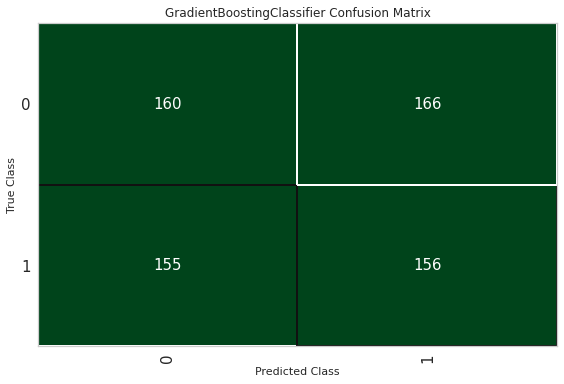

In [58]:
plot_model(MODEL, plot = 'confusion_matrix')

In [59]:
TUNED_MODEL = tune_model(MODEL)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.4698,0.4701,0.4800,0.4737,0.4768,-0.0605,-0.0606
1,0.5772,0.6121,0.5867,0.5789,0.5828,0.1542,0.1543
2,0.5034,0.5333,0.5467,0.5062,0.5256,0.0061,0.0061
3,0.5570,0.5905,0.5658,0.5658,0.5658,0.1137,0.1137
4,0.4698,0.4416,0.5263,0.4819,0.5031,-0.0628,-0.0631
5,0.5405,0.5173,0.5600,0.5455,0.5526,0.0806,0.0806
6,0.4932,0.5120,0.5067,0.5000,0.5033,-0.0139,-0.0139
7,0.4392,0.4504,0.4400,0.4459,0.4430,-0.1216,-0.1216
8,0.5473,0.5145,0.6000,0.5488,0.5732,0.0933,0.0937
9,0.4730,0.4402,0.4667,0.4795,0.4730,-0.0539,-0.0539


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


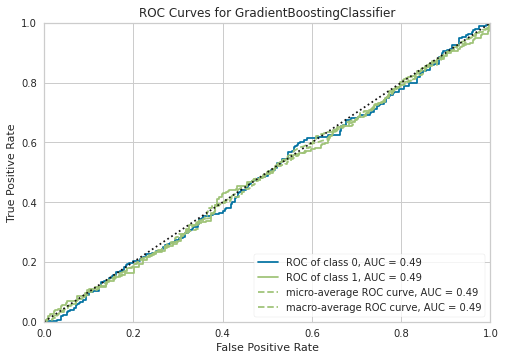

In [60]:
plot_model(TUNED_MODEL, plot = 'auc')

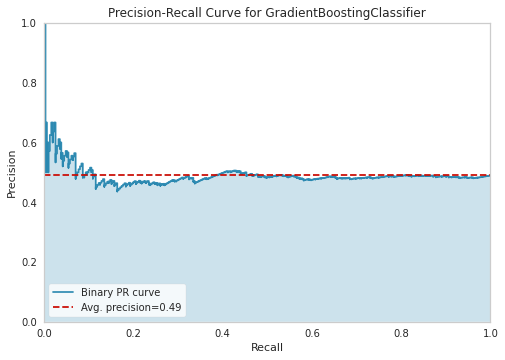

In [61]:
plot_model(TUNED_MODEL, plot = 'pr')

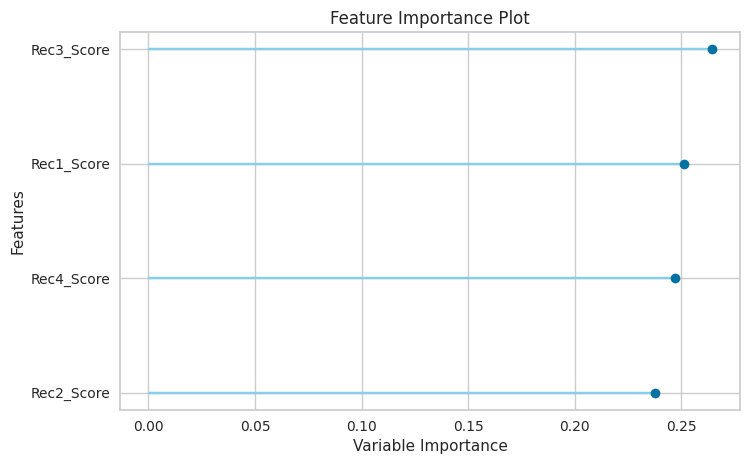

In [62]:
plot_model(TUNED_MODEL, plot='feature')

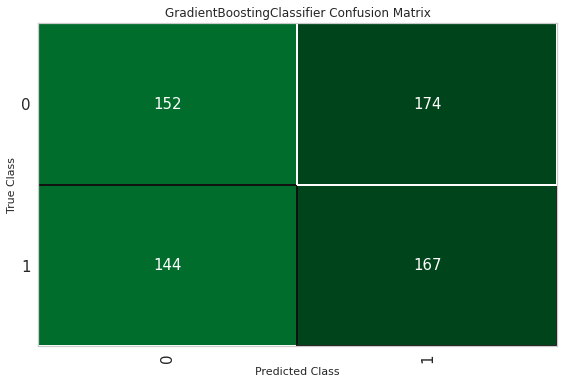

In [63]:
plot_model(TUNED_MODEL, plot = 'confusion_matrix')

In [64]:
predict_model(TUNED_MODEL);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.5008,0.4900,0.5370,0.4897,0.5123,0.0032,0.0032


In [65]:
FINAL_MODEL = finalize_model(TUNED_MODEL)

In [66]:
print(FINAL_MODEL)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.3, loss='deviance', max_depth=5,
                           max_features=1.0, max_leaf_nodes=None,
                           min_impurity_decrease=0.0005,
                           min_impurity_split=None, min_samples_leaf=3,
                           min_samples_split=7, min_weight_fraction_leaf=0.0,
                           n_estimators=160, n_iter_no_change=None,
                           presort='deprecated', random_state=123,
                           subsample=0.45, tol=0.0001, validation_fraction=0.1,
                           verbose=0, warm_start=False)


In [67]:
predict_model(FINAL_MODEL);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.9874,0.9967,0.9904,0.9840,0.9872,0.9749,0.9749


In [68]:
unseen_predictions = predict_model(FINAL_MODEL, data=data_unseen)
unseen_predictions.head()

,Current_Market,Rec1_Score,Rec2_Score,Rec3_Score,Rec4_Score,Label,Score
0,1,4.01,55.47,-80.77,-41.49,0,0.5655
1,1,88.29,67.92,-53.35,86.97,1,0.9616
2,0,47.93,12.52,-71.36,-60.25,0,0.6663
3,1,89.33,-92.15,59.83,88.08,1,0.8634
4,0,-22.94,-67.17,-62.58,-8.26,0,0.7287


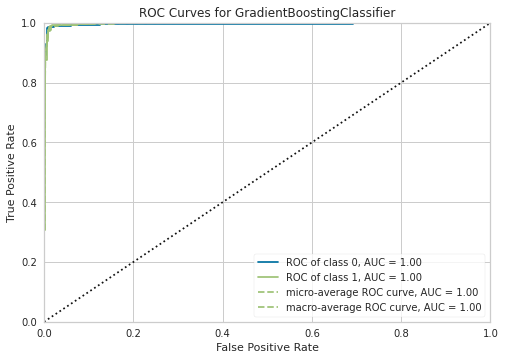

In [69]:
plot_model(FINAL_MODEL, plot = 'auc')

In [70]:
pkl_name = (today + "_" + model + "_" + pair)

In [71]:
save_model(FINAL_MODEL, pkl_name)

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[],
                                       target='Current_Market',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 nume...
                                             learning_rate=0.3, loss='deviance',
                                             max_depth=5, max_features=1.0,
                                             max_leaf_nodes=None,
            

In [72]:
SAVED_FINAL_MODEL = load_model(pkl_name)

Transformation Pipeline and Model Successfully Loaded


In [73]:
new_prediction = predict_model(SAVED_FINAL_MODEL, data=data_unseen)

In [74]:
data_unseen.shape

(910, 5)

In [75]:
new_prediction.head(20)

,Current_Market,Rec1_Score,Rec2_Score,Rec3_Score,Rec4_Score,Label,Score
0,1,4.01,55.47,-80.77,-41.49,0,0.5655
1,1,88.29,67.92,-53.35,86.97,1,0.9616
2,0,47.93,12.52,-71.36,-60.25,0,0.6663
3,1,89.33,-92.15,59.83,88.08,1,0.8634
4,0,-22.94,-67.17,-62.58,-8.26,0,0.7287
5,0,-1.04,-0.20,-77.01,-74.12,0,0.9062
6,1,73.10,80.12,-48.49,-0.67,1,0.8654
7,1,72.50,53.41,-0.51,-0.57,0,0.6109
8,1,-96.08,32.91,-25.67,-66.47,1,0.9962
9,0,7.98,27.70,62.93,-38.70,0,0.6151


In [76]:
file = open(today + "_" + model + "_binary_classification_log_" + pair + ".txt", "w")
file.write ("Date: " + today + "\n" + \
            "Currency Pair: " + pair + "\n" + \
            "Model: " + model + "\n" + \
            "Frac: " + str(frac) + "\n" + \
            "Random State: " + str(random_state) + "\n" )
file.close()

### Final Test

In [77]:
filename = '{}_H4.csv'.format(instrument)
data = pd.read_csv(filename)

In [78]:
random_samples = data[data[volume] > volume_size].sample(n = sample_count)
Test_Candle = list(random_samples.index.values)

In [79]:
#LR_FINAL_MODEL = load_model('FINAL_MODELS/EURUSD/FINAL_LR_25Nov2021_EURUSD')
#ET_FINAL_MODEL = load_model('FINAL_MODELS/EURUSD/FINAL_ET_25Nov2021_EURUSD')
#KNN_FINAL_MODEL = load_model('02-02-2022_03-42_AM_knn_EUR_USD')
#DT_FINAL_MODEL = load_model('FINAL_MODELS/USDCAD/10-01-2022_06-15_AM_dt_USDCAD')
GBC_FINAL_MODEL = load_model('10-02-2022_03-50_AM_gbc_EUR_USD')
#LIGHTGBM_FINAL_MODEL = load_model('03-02-2022_06-56_PM_lightgbm_EURUSD')

Transformation Pipeline and Model Successfully Loaded


In [80]:
%%time
print ('Today: ' + today)

result_output = pd.DataFrame({'Candle_No':[],
                              'Current_Market_Fit':[],
                              'Current_Market':[],
#                              'Rec1':[],
#                              'Rec1_P':[],
#                              'Rec2':[],
#                              'Rec2_P':[],
#                              'Rec3':[],
#                              'Rec3_P':[],
#                              'LR_Label':[],
#                              'LR_Score':[],
#                              'ET_Label':[],
#                              'ET_Score':[],
#                              'KNN_Label':[],
#                              'KNN_Score':[],
#                              'DT_Label':[],
#                              'DT_Score':[],
#                              'LIGHTGBM_Label':[],
#                              'LIGHTGBM_Score':[],
                              'GBC_Label':[],
                              'GBC_Score':[],                              
                             })

for candle_no in Test_Candle:
    data = pd.read_csv(filename)
    data = data.iloc[candle_no:candle_no+candles]
    data['candleno'] = range (1, len(data) + 1)
    X = data['candleno'].values.reshape(-1, 1)
    Y = data['Close'].values.reshape(-1, 1)
    linear_regressor = LinearRegression()
    linear_regressor.fit(X, Y)
    y_pred = linear_regressor.predict(X) 
    
    Current_Market_Fit = r2_score(Y, y_pred)*100
    coeficient = (linear_regressor.coef_)

    if coeficient > 0:
        Current_Market= 1

    else:
        Current_Market = 0

    data = pd.read_csv(filename)
    data = data[[feature_1,
                 feature_2,
                 feature_3,
#                 feature_12,
#                 feature_13,
#                 feature_14,
                ]]

    indices, distances = find_k_similar_candles (candle_no,data)
    indices = indices[0:1][0]
    
    predicted_output = []
    recs = []
    for indice in indices[1:5]:
             
        Predicted_Market_Fit =0
        Predicted_Trade=''
    
        data = pd.read_csv(filename) 
        data = data.iloc[indice:indice+candles]

        data['candleno'] = range (1, len(data) + 1)
        X = data['candleno'].values.reshape(-1, 1)
        Y = data['Close'].values.reshape(-1, 1)
        linear_regressor = LinearRegression()
        linear_regressor.fit(X, Y)
        y_pred = linear_regressor.predict(X)

        Predicted_Market_Fit= r2_score(Y, y_pred)*100
        coeficient = (linear_regressor.coef_)

        if coeficient > 0:
            Predicted_Trade = 'BUY'
            recs.append((r2_score(Y, y_pred)*100))
        else:
            Predicted_Trade = 'SELL'
            recs.append((r2_score(Y, y_pred)*100) * -1)
        
        predicted_output.append([Predicted_Market_Fit,Predicted_Trade])
        
        
    data_unseen = pd.DataFrame ({
        'Rec1_Score': [recs[0]],
        'Rec2_Score': [recs[1]],
        'Rec3_Score': [recs[2]],
        'Rec4_Score': [recs[3]],
    })
    
#    lr_prediction = predict_model(LR_FINAL_MODEL, data=data_unseen)
#    LR_Label = lr_prediction['Label']
#    LR_Score = lr_prediction['Score']
    
#    et_prediction = predict_model(ET_FINAL_MODEL, data=data_unseen)
#    ET_Label = et_prediction['Label']
#    ET_Score = et_prediction['Score']
    
#    knn_prediction = predict_model(KNN_FINAL_MODEL, data=data_unseen)
#    KNN_Label = knn_prediction['Label']
#    KNN_Score = knn_prediction['Score']
    
#    dt_prediction = predict_model(DT_FINAL_MODEL, data=data_unseen)
#    DT_Label = dt_prediction['Label']
#    DT_Score = dt_prediction['Score']
    
#    lightgbm_prediction = predict_model(LIGHTGBM_FINAL_MODEL, data=data_unseen)
#    LIGHTGBM_Label = lightgbm_prediction['Label']
#    LIGHTGBM_Score = lightgbm_prediction['Score']

    gbc_prediction = predict_model(GBC_FINAL_MODEL, data=data_unseen)
    GBC_Label = gbc_prediction['Label']
    GBC_Score = gbc_prediction['Score']    
    
    result = {'Candle_No': candle_no,
              'Current_Market_Fit': Current_Market_Fit,
              'Current_Market': Current_Market,
#              'Rec1': predicted_output[0][0],
#              'Rec1_P': predicted_output[0][1],
#              'Rec2': predicted_output[1][0],
#              'Rec2_P': predicted_output[1][1],
#              'Rec3': predicted_output[2][0],
#              'Rec3_P': predicted_output[2][1],
#              'LR_Label': LR_Label[0],
#              'LR_Score': LR_Score[0],
#              'ET_Label': ET_Label[0],
#              'ET_Score': ET_Score[0],
#              'KNN_Label': KNN_Label[0],
#              'KNN_Score': KNN_Score[0],
#              'DT_Label': DT_Label[0],
#              'DT_Score': DT_Score[0],
#              'LIGHTGBM_Label': LIGHTGBM_Label[0],
#              'LIGHTGBM_Score': LIGHTGBM_Score[0],
              'GBC_Label': GBC_Label[0],
              'GBC_Score': GBC_Score[0],              
             }
    
    result_output = result_output.append(result, ignore_index = True)

Today: 10-02-2022_03-50_AM


/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forex

/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)


CPU times: user 3h 2min 6s, sys: 4h 24min 20s, total: 7h 26min 26s
Wall time: 35min 27s


In [81]:
result_output.to_csv('03_Back_Test_Final_Result_' + today + '.csv', header = True, index = False)
result_output = pd.read_csv('03_Back_Test_Final_Result_' + today + '.csv')

In [82]:
result_output = result_output[result_output['Current_Market_Fit'] > 20]
result_output = result_output.reset_index()
del result_output['index']

In [83]:
result_output.shape

(2845, 5)

In [84]:
result_output.to_csv('03_Back_Test_Final_Result_' + today + '.csv', header = True, index = False)
result_output = pd.read_csv('03_Back_Test_Final_Result_' + today + '.csv')

In [85]:
#result_output['LR_Prediction'] = result_output['Current_Market'] - result_output['LR_Label']
#result_output['ET_Prediction'] = result_output['Current_Market'] - result_output['ET_Label']
#result_output['KNN_Prediction'] = result_output['Current_Market'] - result_output['KNN_Label']
#result_output['DT_Prediction'] = result_output['Current_Market'] - result_output['DT_Label']
#result_output['LIGHTGBM_Prediction'] = result_output['Current_Market'] - result_output['LIGHTGBM_Label']
result_output['GBC_Prediction'] = result_output['Current_Market'] - result_output['GBC_Label']

In [86]:
GBC_Result = pd.DataFrame(result_output['GBC_Prediction'].value_counts())
GBC_Result["Score"] = (GBC_Result['GBC_Prediction'] * 100 / len(result_output)).round(2)

In [87]:
result = pd.concat([
#    LR_Result,
#    ET_Result,
#    KNN_Result,
#    DT_Result,
    GBC_Result,
#    LIGHTGBM_Result,
], axis=1)
result

,GBC_Prediction,Score
0.0,2196,77.19
1.0,333,11.70
-1.0,316,11.11
